# Este programa faz a preparacao dos dados para executar a previsão 
# de vacinados no Banco Dados coletado da APIs Vacina do site gov.br:

## Desse Banco de Dados, foi gerado uma Amostra randomicamente,
## definindo uma porcentage de 0.001 ==> 1 em cada 1.000

In [ ]:
# DATA ; 17/5/2021

In [1]:
import csv
import time
import requests 
import pandas  as pd
import seaborn as sns
from random   import random
from prophet  import Prophet
from datetime import datetime
from datetime import date


# Importar bibliotecas para construir gráficos:

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Bibliotecas de Algoritmos de Regressão:
from sklearn.tree            import DecisionTreeClassifier
from catboost                import CatBoostClassifier
from sklearn.metrics         import accuracy_score
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor


# Biblioteca do Prophet para Algoritmo de Previsão:

from prophet import Prophet


df = pd.read_csv("BD_Amostra-Alguns-12-05-2021.csv", sep=";")
usecols   = ['vacina_fabricante_nome',
             'paciente_idade',
             'paciente_id',
             'vacina_dataAplicacao',
             'paciente_endereco_uf',
             'vacina_descricao_dose']

# Leitura do mesmo Banco Dados da Amostra no dia 12/05/2021:



In [2]:
# Denindo as Variaveis Globais:

FATOR_AMOSTRA = 0.001 # 1/1000

In [ ]:
# Trabalhando com arquivo de Amostra, usarei algumas colunas
# relevantes para tratar com a Previsao Vacinados.

## Leitura BD_Amostra do dia 12/05/2021:
## DataFrame conterá as colunas dos vacinados 1.Dose e 2. Dose

In [ ]:
# Primeiro passo: cuidar do campo 'vacina_dataAplicacao' para ter somente a DATA

In [5]:
# Preparando o campo para o datetime: formato = %Y-%m-%dT%H:%M:%S"


In [3]:
df['vacina_dataAplicacao']

0        2021-02-06T00:00:00.000Z
1        2021-03-06T00:00:00.000Z
2        2021-04-13T00:00:00.000Z
3        2021-03-30T00:00:00.000Z
4        2021-03-17T00:00:00.000Z
                   ...           
50934    2021-05-12T00:00:00.000Z
50935    2021-05-11T00:00:00.000Z
50936    2021-05-03T00:00:00.000Z
50937    2021-04-01T00:00:00.000Z
50938    2021-05-11T00:00:00.000Z
Name: vacina_dataAplicacao, Length: 50939, dtype: object

In [ ]:
# Preciso tratar o campo 'vacina_dataAplicacao' :
# 1) aparecer o DD/MM/YY
# 2) remover o timezone

In [4]:
# converter a coluna datetime  somente em date

df['vacina_dataAplicacao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.date


df.dtypes


vacina_fabricante_nome    object
paciente_idade             int64
paciente_id               object
vacina_dataAplicacao      object
paciente_endereco_uf      object
vacina_descricao_dose     object
dtype: object

In [11]:
# Note que o cmpo 'vacina_dataAplicao' é tipo = object
# Preciso usar a função: normalize()  que será mostrado no campo date:
#  'vacina_dataAplicacao' tem que ser ==> datetime64 
# 

df['vacina_dataAplicao'] = pd.to_datetime(df['vacina_dataAplicacao']).dt.normalize()

# Vericando os tipos do DataFrame:
df.dtypes

vacina_fabricante_nome            object
paciente_idade                     int64
paciente_id                       object
vacina_dataAplicacao              object
paciente_endereco_uf              object
vacina_descricao_dose             object
vacina_dataAplicao        datetime64[ns]
dtype: object

In [5]:
df['vacina_dataAplicacao']

0        2021-02-06
1        2021-03-06
2        2021-04-13
3        2021-03-30
4        2021-03-17
            ...    
50934    2021-05-12
50935    2021-05-11
50936    2021-05-03
50937    2021-04-01
50938    2021-05-11
Name: vacina_dataAplicacao, Length: 50939, dtype: object

In [2]:
# Segundo Passo: tratando do campo "vacina_descricao_dose"

In [ ]:
# Para a aplicação da Vacina se:
#   Primeira Dose 
#   Segunda Dose após um intervalo definido

In [6]:
df["vacina_descricao_dose"].unique()


array(['\xa0\xa0\xa0\xa01ª\xa0Dose', '\xa0\xa0\xa0\xa02ª\xa0Dose',
       '1ª Dose', '2ª Dose', 'Única'], dtype=object)

In [65]:
# Note que no campo contém a seguinte descrição:

# array(['\xa0\xa0\xa0\xa01ª\xa0Dose', 
#        '\xa0\xa0\xa0\xa02ª\xa0Dose']
#        '1ª Dose', '2ª Dose', 'Única'



In [7]:
# Fazendo uma limpeza do campo "vacina_descricao_dose" 
# nos dois DataFrames:

# 1) Transformando todos as linhas como Minuúsculas
# 2) Quando aparecer Null (NaN) substitui-se por "-"
# 3) Tratando todos os caracteres ASCII 

df["vacina_descricao_dose"] = (df["vacina_descricao_dose"]
                                 .str.lower()
                                 .str.normalize("NFKD")
                                 .str.lstrip()
                                 .str.replace(" ","_")
                                 .str.encode("ascii", errors="ignore")
                                 .str.decode("utf-8"))

# Mineirando os Dados:

# Vou tratar o campo 'vacina_descricao_dose':

## Teremos 3 situações para contabilizar o número de vacinas tomadas:
##  (1) A Primeira Dose ==> 1a_dose
##  (2) A Segunda Dose  ==> Totalmente vacinados com a  2a_dose
##  (3) Ser Dose Unica!!

In [8]:
df["vacina_descricao_dose"].value_counts



<bound method IndexOpsMixin.value_counts of 0        1a_dose
1        2a_dose
2        1a_dose
3        1a_dose
4        2a_dose
          ...   
50934    1a_dose
50935    2a_dose
50936    2a_dose
50937    1a_dose
50938    1a_dose
Name: vacina_descricao_dose, Length: 50939, dtype: object>

# Usando Get_Dummies para descrever as 


In [9]:

dummies = df["vacina_descricao_dose"].str.get_dummies("\n")


In [10]:
# Concatenar com o DataFrame e a coluna já tratada como 1. Dose :

df = pd.concat([df, dummies], axis = 1)

In [11]:
dummies.head(5)

,1a_dose,2a_dose,unica
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,1,0


In [12]:
Vacinados_uma_dose = df['1a_dose'].sum()


print('Vacinados com 1. dose = ', Vacinados_uma_dose/FATOR_AMOSTRA)

Vacinados com 1. dose =  34874000.0


In [13]:
Vacinados_duas_doses = df['2a_dose'].sum()


print('Vacinados com 2. dose = ', Vacinados_duas_doses/FATOR_AMOSTRA)

Vacinados com 2. dose =  16064000.0


In [23]:
# Limpando os campos das Doses, retirando os nulos NaN

df['1a_dose'].fillna(0, inplace = True)

df['2a_dose'].fillna(0, inplace = True)

df['unica'].fillna(0, inplace = True)


<AxesSubplot:xlabel='count', ylabel='vacina_descricao_dose'>

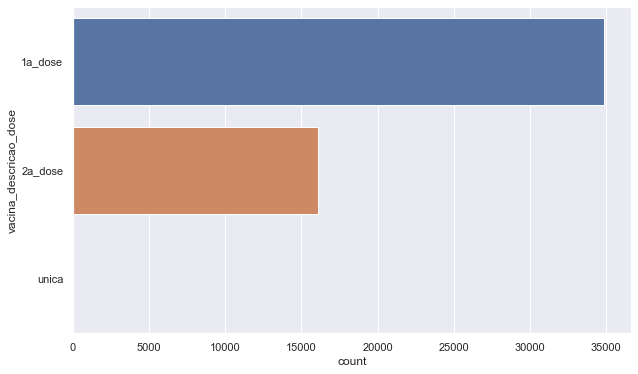

In [24]:
plt.figure(figsize = (10,6))
sns.countplot(data = df, y = "vacina_descricao_dose")

In [25]:
df['vacina_dataAplicacao']

0        2021-02-06
1        2021-03-06
2        2021-04-13
3        2021-03-30
4        2021-03-17
            ...    
50934    2021-05-12
50935    2021-05-11
50936    2021-05-03
50937    2021-04-01
50938    2021-05-11
Name: vacina_dataAplicacao, Length: 50939, dtype: object

# Trabalhando com informações da 1a_dose para rodar a PREVISAO:

In [26]:
df1 = df.groupby('vacina_dataAplicacao').agg({'1a_dose':'sum'}).reset_index()

df1['vacina_dataAplicacao'].value_counts()


2021-02-08    1
2021-03-02    1
2021-01-20    1
2021-04-28    1
2021-01-23    1
             ..
2021-03-11    1
2021-05-09    1
2021-01-29    1
2021-04-11    1
2021-04-06    1
Name: vacina_dataAplicacao, Length: 115, dtype: int64

In [29]:
df1.head(3)

,vacina_dataAplicacao,1a_dose
0,2021-01-18,2
1,2021-01-19,64
2,2021-01-20,297


# Terceiro Passo: 
# Usar o Algoritmo do Prophets do Facebook para Previsao:

## ds = 'vacina_dataAplicacao' 
## ds é a coluna de carimbo de data e deve ser conforme o formato de 
## data / hora do pandas , AAAA-MM-DD


## A coluna y = deve ser numérica e representa a medida que desejamos prever
## y = total da 1. dose para dataframe == df1 ou 2.dose para dataframe == df2

In [31]:
df1.columns = ['ds', 'y']

In [32]:
df1.head(3)

,ds,y
0,2021-01-18,2
1,2021-01-19,64
2,2021-01-20,297


In [33]:
df1.ds.max()

datetime.date(2021, 5, 12)

# Rodando o Algorítmo de Previsao PROPHETS para '1a_dose'

In [37]:
m = Prophet()

m.fit(df1)
future = m.make_future_dataframe(periods = 180, include_history=False)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
future

,ds
0,2021-05-13
1,2021-05-14
2,2021-05-15
3,2021-05-16
4,2021-05-17
...,...
175,2021-11-04
176,2021-11-05
177,2021-11-06
178,2021-11-07


In [39]:
future.min()

ds   2021-05-13
dtype: datetime64[ns]

In [40]:
future.max()

ds   2021-11-08
dtype: datetime64[ns]

In [41]:
valores_futuro = m.predict(future)

valores_futuro

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-13,372.836488,238.444934,666.771933,372.836488,372.836488,73.057084,73.057084,73.057084,73.057084,73.057084,73.057084,0.0,0.0,0.0,445.893572
1,2021-05-14,373.737850,203.379848,644.540049,373.718694,373.758955,58.281519,58.281519,58.281519,58.281519,58.281519,58.281519,0.0,0.0,0.0,432.019369
2,2021-05-15,374.639212,96.185103,516.938424,374.592065,374.693950,-72.006968,-72.006968,-72.006968,-72.006968,-72.006968,-72.006968,0.0,0.0,0.0,302.632244
3,2021-05-16,375.540574,-93.575012,346.767275,375.450295,375.637833,-249.085806,-249.085806,-249.085806,-249.085806,-249.085806,-249.085806,0.0,0.0,0.0,126.454768
4,2021-05-17,376.441936,233.069806,671.673265,376.301177,376.590802,66.991175,66.991175,66.991175,66.991175,66.991175,66.991175,0.0,0.0,0.0,443.433111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2021-11-04,530.574840,386.774078,829.779522,491.625673,570.714358,73.057084,73.057084,73.057084,73.057084,73.057084,73.057084,0.0,0.0,0.0,603.631924
176,2021-11-05,531.476202,375.174521,820.982303,492.182059,572.022902,58.281519,58.281519,58.281519,58.281519,58.281519,58.281519,0.0,0.0,0.0,589.757721
177,2021-11-06,532.377564,253.343783,678.470310,492.655225,573.219960,-72.006968,-72.006968,-72.006968,-72.006968,-72.006968,-72.006968,0.0,0.0,0.0,460.370596
178,2021-11-07,533.278926,62.414501,499.269637,493.187189,574.397331,-249.085806,-249.085806,-249.085806,-249.085806,-249.085806,-249.085806,0.0,0.0,0.0,284.193120


# Rodando o Algorítmo de Previsao PROPHETS para '2a_dose'

In [ ]:
df2 = df.groupby('vacina_dataAplicacao').agg({'2a_dose':'sum'}).reset_index()

df2['vacina_dataAplicacao'].value_counts()


In [42]:
df2.head()

,vacina_dataAplicacao,2a_dose
0,2021-01-18,0
1,2021-01-19,0
2,2021-01-20,0
3,2021-01-21,1
4,2021-01-22,2


In [ ]:
# Neste ponto é NECESARIO reset no codigo para executar o PROPHETS

In [ ]:
m = Prophet()

m.fit(df2)

future = m.make_future_dataframe(periods = 180, include_history=False)